## Lyft Challenge!

https://www.udacity.com/lyft-challenge

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import pdb
from pathlib import Path

In [4]:
PATH = Path('data/lyft')
list(PATH.iterdir())

[PosixPath('data/lyft/train_masks'),
 PosixPath('data/lyft/train'),
 PosixPath('data/lyft/car_masks'),
 PosixPath('data/lyft/models'),
 PosixPath('data/lyft/tmp')]

In [5]:
VEHICLES = 10 # Data encoding in the segmented image
ROADS = 7
ROAD_LINES = 6

def isolate_cars(filename):
    img = Image.open(filename)

    img_np = np.array(img)

    img_np_R = img_np[:,:,0] # Pull out R channel

    img_np_R[img_np_R == VEHICLES] = 255    

    img_np_R[img_np_R != 255] = 0
    
    h,w = img_np_R.shape
    img_np_R[int(.82*h):h, :] = 0

    new_img = np.stack((img_np_R,img_np_R,img_np_R), axis=-1)
    
    image = Image.fromarray(new_img, 'RGB')
    dest = Path('data/lyft/car_masks')
    image.save(dest/filename.name)

In [6]:
def show_img(im, figsize=(8,8), ax=None, alpha=None):
    if not ax: fix, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

The following code takes the original labelled images and converts them to a more usable format. **Run this next cell only once.**

In [7]:
seg_PATH = Path('train/CameraSeg')
original_segs = list(seg_PATH.iterdir())

# for file in original_segs:
#     isolate_cars(file)

In [8]:
input_images = PATH/'train'
output_images = PATH/'car_masks'

list(input_images.iterdir())[:3]

[PosixPath('data/lyft/train/5.png'),
 PosixPath('data/lyft/train/88.png'),
 PosixPath('data/lyft/train/0.png')]

In [9]:
list(output_images.iterdir())[:3]

[PosixPath('data/lyft/car_masks/5.png'),
 PosixPath('data/lyft/car_masks/88.png'),
 PosixPath('data/lyft/car_masks/0.png')]

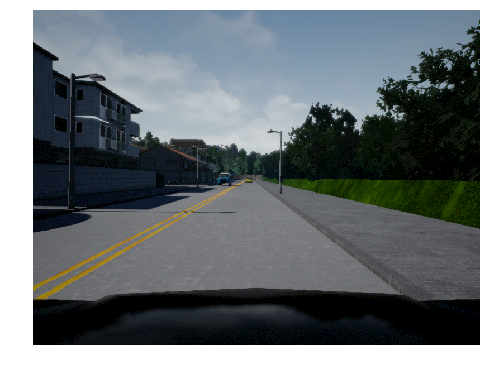

In [10]:
real_world = open_image(list(input_images.iterdir())[0])
show_img(real_world)

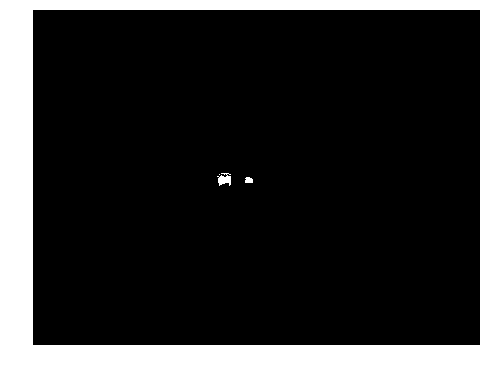

In [11]:
test_seg_image = open_image(list(output_images.iterdir())[0])
show_img(test_seg_image)

## Visualize data

In [12]:
TRAIN_DN = 'train'
MASKS_DN = 'car_masks'
sz = 128
bs = 64

In [13]:
ims = [open_image(list(input_images.iterdir())[i]) for i in range(16)]
masks = [open_image(list(output_images.iterdir())[i]) for i in range(16)]

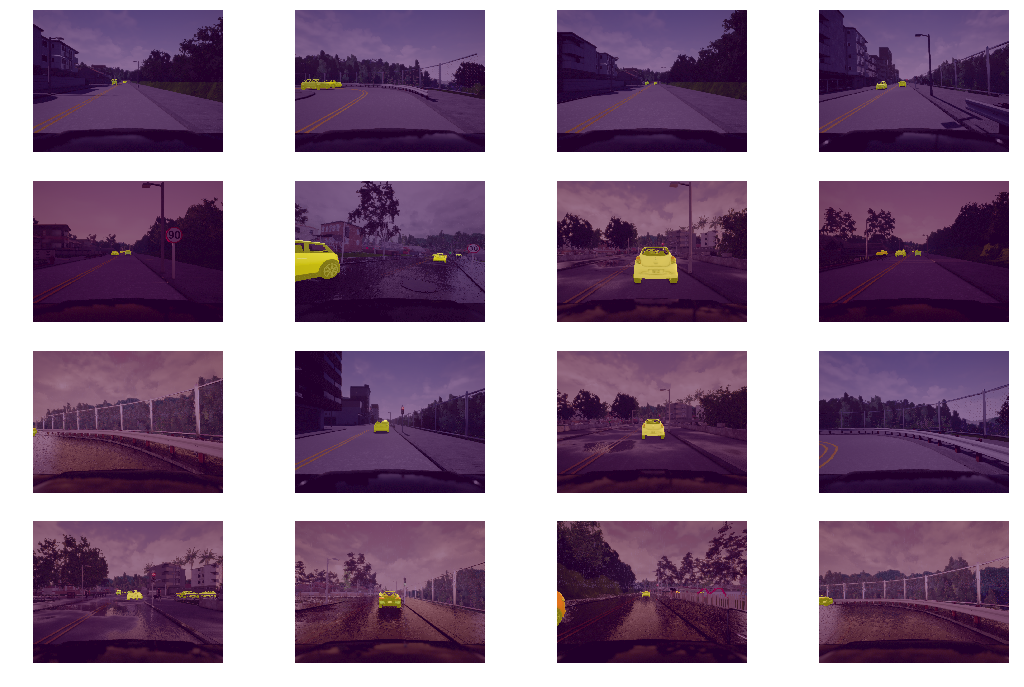

In [14]:
fig, axes = plt.subplots(4,4, figsize=(18,12))
for i, ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(masks[i][...,0], ax=ax, alpha=0.5)

In [15]:
class MatchedFilesDatset(FilesDataset):
    def __init__(self, filenames, y, transform, path):
        assert(len(filenames == len(y)))
        self.y = y
        super().__init__(filenames, transform, path)
        
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    
    def get_c(self): return 0

In [16]:
x_names = np.array(list((PATH/TRAIN_DN).iterdir()))
y_names = np.array(list((PATH/MASKS_DN).iterdir()))

len(x_names), len(y_names)

(1000, 1000)

In [17]:
# val_idxs = list(range(len(x_names)//5)) # 20% validation split
val_idxs = list(range(0,1000,5)) # better 20% validation split
((val_x, trn_x),(val_y, trn_y)) = split_by_idx(val_idxs, x_names, y_names) # split the in/out pairs the same

In [18]:
len(val_x), len(trn_x), trn_x[0], trn_y[0]

(200,
 800,
 PosixPath('data/lyft/train/88.png'),
 PosixPath('data/lyft/car_masks/88.png'))

In [19]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05)]

In [20]:
transforms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDatset, (trn_x,trn_y), (val_x,val_y), transforms, path='')
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [21]:
# Use this cell to print the denormed image for visualization purposes
# denorm = md.trn_ds.denorm
# x,y = next(iter(md.aug_dl))
# x = denorm(x)

In [23]:
# This cell is for educational purposes, to see inside the resnet arch

# class Empty(nn.Module): 
#     def forward(self,x): return x

# models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=Empty())
# learn = ConvLearner(md, models)
# learn.summary()

In [24]:
from lyft_helpers import *

In [25]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

epoch      trn_loss   val_loss   <lambda>                  
    0      0.705322   223862.93875 0.928371  



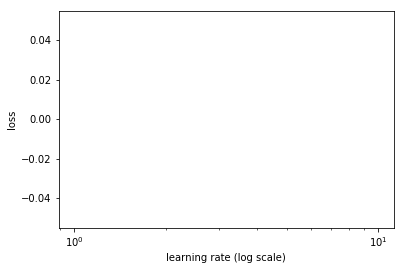

In [26]:
learn.lr_find()
learn.sched.plot()

In [27]:
lr=4e-2

In [28]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.420101   18.091281  0.225721  
    1      0.224427   4.738551   0.682207                  
    2      0.149804   0.142311   0.955749                  
    3      0.11034    0.047998   0.985983                  
    4      0.085809   0.032744   0.988998                   



[array([0.03274]), 0.988997802734375]

In [29]:
learn.save('tmp')

In [30]:
torch.save(learn.model, 'car-fullmodel-2.pt')

/home/officialdanielhunter/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type StdUpsample. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [31]:
learn.load('tmp')

In [33]:
# py,ay = learn.predict_with_targs()

In [34]:
# ay.shape

In [32]:
# show_img(ay[5]);

In [35]:
# show_img(py[5]>0);

In [36]:
learn.unfreeze()

In [37]:
learn.bn_freeze(True)

In [38]:
lrs = np.array([lr/100, lr/10, lr])/4

In [39]:
learn.fit(lrs, 1, cycle_len=20, use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.061677   0.050808   0.986235  
    1      0.062904   0.053031   0.986943                   
    2      0.059225   0.035265   0.987976                   
    3      0.049707   0.026259   0.990697                   
    4      0.042106   0.024102   0.99136                    
    5      0.036408   0.021169   0.992205                   
    6      0.032033   0.019964   0.992474                   
    7      0.028627   0.018494   0.992694                   
    8      0.02591    0.017787   0.993043                   
    9      0.023647   0.016681   0.993176                   
    10     0.021814   0.016728   0.993259                   
    11     0.020376   0.015875   0.993358                   
    12     0.019134   0.015898   0.992983                   
    13     0.018121   0.015248   0.993415                   
    14     0.017274   0.014766   0.993558                   
    15     0.01652    0.014591   0.993899

[array([0.01387]), 0.9939718627929688]

In [40]:
torch.save(learn.model, 'car-fullmodel-2.pt')

/home/officialdanielhunter/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type StdUpsample. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [41]:
# py,ay = learn.predict_with_targs()

In [42]:
# show_img(ay[5]);

In [43]:
# show_img(py[5]>0);

In [48]:
learn.save('car-128')

In [45]:
# torch.save(learn.model, 'car-fullmodel.pt')
# torch.save(learn.model.state_dict(), 'road-weights.pt')

In [46]:
sz = 512
bs = 16

In [47]:
transforms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDatset, (trn_x,trn_y), (val_x,val_y), transforms, path='')
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [49]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [50]:
learn.load('car-128')

 78%|███████▊  | 39/50 [00:56<00:15,  1.45s/it, loss=0.961] 

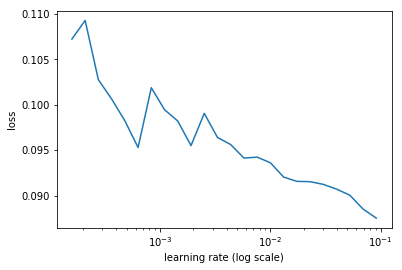

In [51]:
learn.lr_find()
learn.sched.plot()

In [52]:
lr=4e-2
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

  0%|          | 0/50 [00:00<?, ?it/s]
epoch      trn_loss   val_loss   <lambda>                   
    0      0.043931   0.034027   0.987765  
    1      0.032599   0.025733   0.990116                   
    2      0.026703   0.021862   0.991112                   
    3      0.023235   0.019902   0.992297                   
    4      0.020983   0.01914    0.992592                   



[array([0.01914]), 0.9925917053222656]

In [53]:
learn.save('car-512')

In [54]:
learn.load('car-512')

In [55]:
learn.unfreeze()
learn.bn_freeze(True)

In [56]:
lrs = np.array([lr/100,lr/10,lr])/4

In [57]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.020177   0.015959   0.993235  
    1      0.014912   0.010311   0.995487                   
    2      0.010881   0.008468   0.996043                   
    3      0.008879   0.007817   0.996284                    
    4      0.007756   0.00743    0.996625                    
    5      0.00706    0.006964   0.996714                    
    6      0.006552   0.006624   0.996877                    
    7      0.006135   0.006474   0.996918                    



[array([0.00647]), 0.996917896270752]

In [58]:
learn.save('car-512-2')

In [59]:
# learn.load('car-128')
torch.save(learn.model, 'car-fullmodel-3.pt')

/home/officialdanielhunter/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type StdUpsample. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [60]:
# py,ay = learn.predict_with_targs()

In [61]:
# show_img(ay[5]);

In [62]:
# show_img(py[5]>0);

In [63]:
# py[5]